In [1]:
from ResearchMain import *

## 数据准备

### 演示数据集
泰坦尼克号数据结构分析：
- Pclass:乘客所持票类，有三种值(1：lower,2：middle,3：upper)
- Survived:0代表死亡，1代表存活
- Name:乘客姓名
- Sex:乘客性别(男：1，女：0)
- Age:乘客年龄(缺失值取平均值)
- SibSp:乘客兄弟姐妹/配偶的个数(整数值)
- Parch:乘客父母/孩子的个数(整数值)
- Ticket:票号(字符串)
- Fare:乘客所持票的价格(浮点数，0-500不等)
- Cabin:乘客所在船舱
- Embark:乘客登船港口:S、C、Q

In [2]:
# 读取演示数据集
# demo_data_name = 'pca_demo_titanic.csv'
# demo_data = pd.read_csv(DATA_PATH+demo_data_name, index_col='PassengerId')
# data.head(3)


In [3]:
# df = demo_data

### 读取分析数据

In [24]:
_ = all_df[[i for i in all_df.columns if
            isinstance(i, str) and i.startswith('S')]].replace(0, 0.00001)
sediment_df = _.drop(['S-Size-d((0.9-0.1)/0.5)', 'S-pH'], axis=1)

water_df = all_df[[i for i in all_df.columns if
                   isinstance(i, str) and i.startswith('W')]].replace(0, 0.00001)
water_df = water_df.drop(['W-PO_{4}^{3-}', 'W-TP'], axis=1)

df = sediment_df
df

,S-TN,S-TP,S-Size-d(0.1),S-Size-d(0.5),S-Size-d(0.9)
D-N1,705,806.285714,11.777,38.340,257.008
D-N2,320,794.285714,45.008,807.765,1239.506
D-N3,420,791.000000,611.957,875.213,1252.883
D-N4,650,768.000000,20.270,53.408,181.770
D-N5,1475,797.714286,9.567,40.619,116.947
...,...,...,...,...,...
W-H8,5325,956.571429,13.179,54.533,177.715
W-H9,5655,924.000000,12.406,46.868,175.772
W-H10,4060,901.142857,12.816,45.730,169.597
W-H11,4060,998.285714,13.281,56.314,187.891


## PCA分析

注意点：

1. 上面经过数据准备后，最后进行PCA分析的数据矩阵应命名为df；
2. 数据表不可以有空值；

### 预检验

首先进行KMO和Bartlett的检验，判断是否可以进行主成分分析。 对于KMO值：0.8上非常合适做主成分分析，0.7-0.8之间一般适合，0.6-0.7之间不太适合，0.5-0.6之间表示差，0.5下表示极不适合，对于 Bartlett的检验（p < 0.05,严格来说p < 0.01），若显著性小于0.05或0.01，拒绝原假设，则说明可以做主成分分析，若不拒绝原假设，则说明这些变量可能独立提供一些信息，不适合做主成分分析；

In [3]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# 巴特利特P值小于0.01，KMO值大于0.6；说明此数据适合做因子分析。
chi_square_value, p_value = calculate_bartlett_sphericity(df)  # 计算巴特利特P值
p_value


1.919821378890126e-40

In [4]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df)
kmo_model


0.823607114773911

<AxesSubplot:>

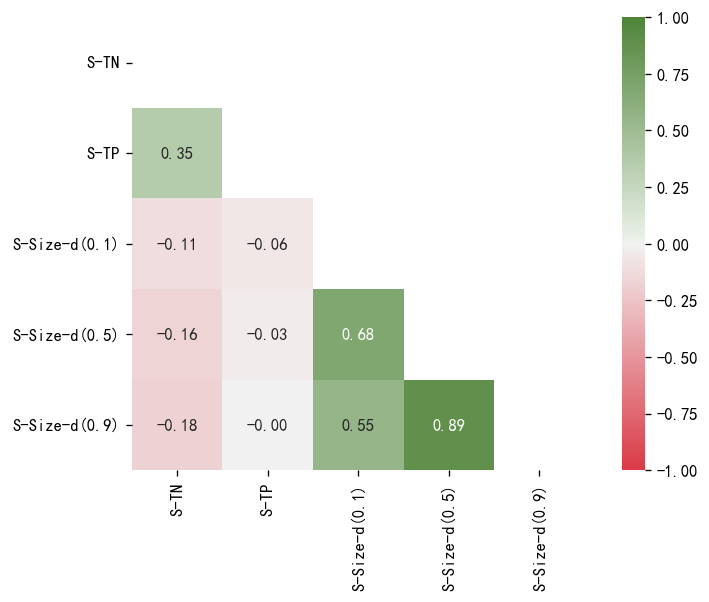

In [4]:
# 查看数据各列之间的相关性
matrix = df.corr()  # 获取各列之间的相关性，这个matrix其实就是X的协方差矩阵
mask = np.triu(np.ones_like(matrix, dtype=bool))  # mask掉上三角部分
plt.figure(figsize=(8, 5), dpi=120)
cmap = sns.diverging_palette(370, 120, n=80, as_cmap=True)
sns.heatmap(matrix, mask=mask, center=0, cmap=cmap, annot=True,
            square=True, fmt='.2f', vmax=1, vmin=-1)
# plt.title('泰坦尼克号数据集各列之间的相关性')


### 数据标准化

In [25]:
# 数据矩阵标准化与中心化
X = (df - df.mean()) / df.std(ddof=0)


这一步是主成分分析（PCA）的数据预处理，首先计算出矩阵中每一列的平均值，然后让每一列中的每一个元素都减去该列的平均值。在进行完这一步之后可以观察每一列数据的分散情况，如果列与列之间的差距仍过大，可以再计算出每一列的方差，然后再将减去平均值后的结果除以每一列的方差（这一步是可选步骤，叫做方差归一化）。

如果两步都做了，这个叫做数据的normalization——对一个非标准的正态分布随机变量转化为标准的正态分布随机变量。

这里一个注意点：
我们使用ddof=1样本标准偏差或ddof=0总体标准偏差作为参数来控制。

### 算法降维处理
在选取特征值的时候，要选取比较大的，特征值大的话数据方差就大，这也就意味着在经过降维后，可以最大程度上保留数据的差异性。

降维的过程实际就是寻找投影方向的过程。

从一个方面讲:

- 好的投影方向，可以使得投影误差最小化。
- 投影误差是各个数据点到投影点距离，这也就意味着经过降维处理后的损失达到最小。

从另一个方面讲:

- 好的投影方向，也就意味着在该方向投影的方差应该最大(分散度/区分度高)，可是使得信息在最大程度上得到保留。
- 复原误差小、重建容易。

降维的步骤：

目标：将n维数据降低为k维(k<n)。
（1）计算协方差矩阵：协方差矩阵（n×n）其实就是原数据矩阵中每两列之间的相关性系数；
（2）计算投影方向：对E进行奇异值分解(Singular Value Decomposition) [U,S,V] = svd (SIGMA)

其中U是一个nxn的矩阵，它每列是SIGMA的一个特征向量(线性代数概念)，U的前k列就是PCA的前k个投影向;我们将U的前k列记为投影矩阵P.
U的每一列都是一个特征向量，因此它的模长都为1，且特征向量之间都是正交的，乘积都为0

计算投影：

- 上一步我们得到了投影矩阵$P \in R^{n \times k}$；
- 对于第i个n维样本$x^{(i)}$，计算$z^{(i)} = x^{(i)} * P$，$z^{(i)}$就是降维后的第i个样本。

$$
X \in R^{m \times n} \times P \in R^{n \times k} = Z \in R^{m \times k}
$$


In [35]:
X

var,S-TN,S-TP,S-Size-d(0.1),S-Size-d(0.5),S-Size-d(0.9)
D-N1,-0.837095,-0.573510,-0.140805,-0.239913,0.343644
D-N2,-0.958229,-0.664953,0.386122,5.537766,4.722972
D-N3,-0.926766,-0.689991,9.375935,6.044239,4.782598
D-N4,-0.854400,-0.865255,-0.006136,-0.126766,0.008282
D-N5,-0.594829,-0.638826,-0.175847,-0.222800,-0.280656
...,...,...,...,...,...
W-H8,0.616504,0.571699,-0.118574,-0.118318,-0.009792
W-H9,0.720332,0.323498,-0.130831,-0.175875,-0.018453
W-H10,0.218494,0.149321,-0.124330,-0.184421,-0.045977
W-H11,0.218494,0.889570,-0.116956,-0.104945,0.035566


In [37]:
-0.926766*(-0.076)-0.031*(-0.689991)+0.203*(9.375935)+0.241*(6.044239)+0.23*(4.782598)

4.551797881000001

In [26]:
# SIGMA  # 各列之间的相关性（可以查看上面使用X.corr()命令获取矩阵X中各列之间的相关性所绘制的热图中的数据其实就是计算了矩阵X的协方差）
# 计算协方差矩阵（代表原矩阵中各列之间的相关性），@用来计算矩阵之间的乘法，.shape[0]获取矩阵中有多少行
SIGMA = (X.T @ X) / X.shape[0]
# 奇异值分解
U, S, V = np.linalg.svd(SIGMA)  # S 是个对角矩阵，是特征值，U是特征值对应的标准正交特征向量
# U
P = U[:, :2]  # 这里取U的前两列就是前两个投影的方向
# P
Z = X @ P  # Z就是经过降维后的矩阵
Z

,0,1
D-N1,0.186270,-0.972115
D-N2,6.500814,0.103155
D-N3,11.421042,1.012195
D-N4,0.156531,-1.207756
D-N5,-0.221916,-0.931803
...,...,...
W-H8,-0.300589,0.797144
W-H9,-0.346982,0.677530
W-H10,-0.254949,0.214850
W-H11,-0.214396,0.770103


In [27]:
X = (df - df.mean()) / df.std(ddof=0)  # 获取经过Normalization的矩阵X
SIGMA = (X.T @ X) / X.shape[0]

# X.corr()
SIGMA  # SIGMA其实就是X.corr()


,S-TN,S-TP,S-Size-d(0.1),S-Size-d(0.5),S-Size-d(0.9)
S-TN,1.000000,0.353520,-0.109101,-0.160839,-0.177991
S-TP,0.353520,1.000000,-0.056207,-0.032779,-0.000428
S-Size-d(0.1),-0.109101,-0.056207,1.000000,0.684153,0.547891
S-Size-d(0.5),-0.160839,-0.032779,0.684153,1.000000,0.890505
S-Size-d(0.9),-0.177991,-0.000428,0.547891,0.890505,1.000000


In [28]:
# V
# ew, ev = np.linalg.eig(X.T.dot(X))
ew, ev = np.linalg.eig(np.cov(X.T))  # ew: 特征值，ev: 特征向量
ew_order = np.argsort(ew)[::-1]  # 将ew按照从大到小的顺序排列
# 特征根，主要是看主成分对于变量解释的贡献率（可以理解为究竟需要多少主成分才能把变量表达为100%），一般都要表达到90%以上才可以，否则就要调整因子数据。
ew_sort = ew[ew_order]
ev_sort = ev[:, ew_order]
# print(ew_sort)


### 方差解释表格
**图表说明:**
上表为总方差解释表格，主要是看主成分对于变量解释的贡献率（可以理解为究竟需要多少主成分才能把变量表达为100%），一般都要表达到90%以上才可以，否则就要调整因子数据。一般情况下,方差解释率越高，说明该主成分越重要，权重占比也应该越高。

方差解释表中，在主成分4时，总方差解释的特征根低于1，变量解释的贡献率达到74.899%，以上仅为参考。
若特征根小于1临界值过大，也可以集合具体情况具体分析。

In [29]:
# 输出一个方差解释表格
var_inter_0 = pd.DataFrame({'特征值': ew_sort})  # 添加特征值列
var_inter_0['百分比'] = (var_inter_0 / var_inter_0.sum())  # 添加百分比列
var_inter_0['累计百分比'] = var_inter_0['百分比'].cumsum()  # 计算累计百分比
var_inter = var_inter_0.copy()
var_inter[['百分比', '累计百分比']] = var_inter[['百分比', '累计百分比']
                                        ].applymap(lambda x: format(x, '.1%'))  # 保留一位小数
# var_inter_0['1'] = 1  # 前两列特征值大于1，且51%以上可以用来解释原来7个变量，因此取前两列
var_inter

,特征值,百分比,累计百分比
0,2.507636,49.6%,49.6%
1,1.326169,26.2%,75.8%
2,0.658040,13.0%,88.8%
3,0.473403,9.4%,98.2%
4,0.090932,1.8%,100.0%


In [17]:
var_inter.to_clipboard()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

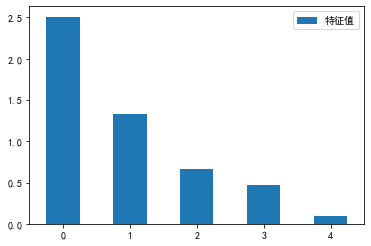

In [30]:
pd.DataFrame(ew_sort).plot(kind='bar').legend(
    ('特征值',))  # 添加图例必须多一个逗号，否则只显示第一个字符
plt.xticks(rotation=0)
# print(ev_sort)


In [31]:
# ev_sort[:, :2]  # 前两列就很大程度上可以用来解释原来7个变量，因此取前两列# V
V = ev_sort[:, :2]  # 前两列就很大程度上可以用来解释原来7个变量，因此取前两列

### 因子数据表

In [34]:
ev_sort

array([[-0.19136624, -0.66359524,  0.69032599, -0.21450888,  0.02136081],
       [-0.07864697, -0.72405553, -0.65159358,  0.21079757, -0.02341878],
       [ 0.5098725 , -0.09353127,  0.28859543,  0.7821749 ,  0.19025518],
       [ 0.60475556, -0.11569722,  0.00895032, -0.22789764, -0.75423301],
       [ 0.57575548, -0.115113  , -0.12453273, -0.49579776,  0.62763908]])

In [32]:
# 构建一个因子数据表
factor_load_table = pd.DataFrame(V)  # 因子载荷数据表，可以分析到每个主成分中隐变量的重要性。
factor_load_table.index = df.columns
factor_load_table.columns = ['PCA 0', 'PCA 1']
factor_load_table.index.name = 'var'
factor_load_table['公共度'] = factor_load_table['PCA 0'] ** 2 + factor_load_table[
    'PCA 1'] ** 2  # 公因子方差：每个变量对应的PCA0与PCA1的平方和
factor_load_table = factor_load_table
factor_load_table

,PCA 0,PCA 1,公共度
var,,,
S-TN,-0.191366,-0.663595,0.476980
S-TP,-0.078647,-0.724056,0.530442
S-Size-d(0.1),0.509872,-0.093531,0.268718
S-Size-d(0.5),0.604756,-0.115697,0.379115
S-Size-d(0.9),0.575755,-0.115113,0.344745


In [ ]:
# U的每一列都是一个特征向量，因此它的模长都为1，且特征向量之间都是正交的，乘积都为0
# (factor_load_table['PCA 0'] * factor_load_table['PCA 1']).sum()  # 两个特征向量的乘积应为0
# (factor_load_table['PCA 0']**2).sum()  # 每一个特征向量的模长都为0
# (factor_load_table['PCA 1']**2).sum()


In [ ]:
plt.figure(figsize=(8, 5), dpi=120)
sns.heatmap(factor_load_table)


### 绘图可视化

In [18]:
# X_new
X_new = X.dot(V)
# 将生存数据添加到DATaFrame中，用于绘制散点图的时候可以区分死亡与生存的区别
# X_new['Survived'] = train_data_0['Survived']
# X_new


<AxesSubplot:xlabel='PCA 0', ylabel='PCA 1'>

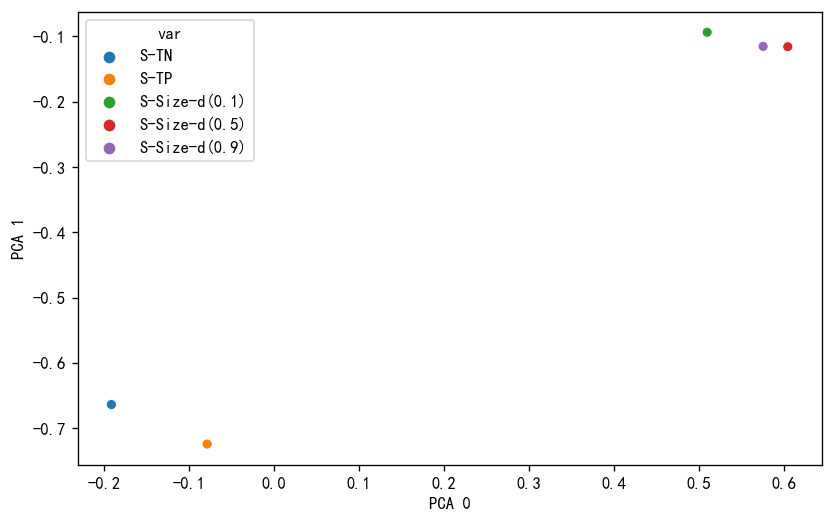

In [13]:
plt.figure(figsize=(8, 5), dpi=120)  # 设置绘图尺寸
sns.scatterplot(x=factor_load_table['PCA 0'],
                y=factor_load_table['PCA 1'], hue=factor_load_table.index)


In [14]:
# scatter
plt.figure(figsize=(8, 5), dpi=120)  # 设置绘图尺寸
sc_survived = plt.scatter(X_new[X_new['Survived'] == 1].iloc[:, 0], X_new[X_new['Survived'] == 1].iloc[:, 1], s=5,
                          c='blue',
                          cmap=plt.cm.coolwarm)  # 提取生存的
sc_un_survived = plt.scatter(X_new[X_new['Survived'] == 0].iloc[:, 0], X_new[X_new['Survived'] == 0].iloc[:, 1], s=5,
                             c='red',
                             cmap=plt.cm.coolwarm)  # c=train_X0.Survived设置颜色反应生还状态，是死是活
# plt.grid(False)  # 是否显示网格线
plt.xlabel('PCA 0')  # 设置X、Y轴坐标名称
plt.ylabel('PCA 1')
plt.legend(handles=[sc_survived, sc_un_survived],
           labels=['生存', '死亡'], loc='upper left')


NameError: name 'X_new' is not defined

<Figure size 960x600 with 0 Axes>

### 成分矩阵表

In [15]:
# 成分矩阵表
composition_matrix = factor_load_table.loc[:, [
    'PCA 0', 'PCA 1']]  # 成分矩阵表 = 因子载荷数据表/对应每一个特征值
composition_matrix['PCA 0'] = composition_matrix['PCA 0'] / \
    ew_sort[0]  # 这里有个问题，有的软件里除的是根号下特征值，有的没有
composition_matrix['PCA 1'] = composition_matrix['PCA 1'] / ew_sort[1]
composition_matrix.round(3)


,PCA 0,PCA 1
var,,
S-TN,-0.076,-0.500
S-TP,-0.031,-0.546
S-Size-d(0.1),0.203,-0.071
S-Size-d(0.5),0.241,-0.087
S-Size-d(0.9),0.230,-0.087


图表说明：
上表为成分矩阵表，意在说明各个成分的所包含的因子得分系数（主成分载荷），用于计算出成分得分，得出因子公式，其计算公式为：线性组合系数*（方差解释率/累积方差解释率），最后将其归一化即为因子权重分。
线性组合系数，公式为：因子载荷系数除以对应特征根，即成分矩阵的系数。
智能分析：
模型的公式：
F1=-0.389×Pclass-0.254×Sex+0.099×Age+0.14×SibSp+0.214×Parch+0.45×Fare-0.212×Embarked
F2=0.262×Pclass-0.166×Sex-0.382×Age+0.411×SibSp+0.392×Parch-0.038×Fare+0.127×Embarked
由上可以得到：
F=(0.265/0.511)×F1+(0.245/0.511)×F2

### 因子权重分析表

In [16]:
factor_weight_analysis = pd.DataFrame(var_inter_0.loc[:1, ['百分比', '累计百分比']])
factor_weight_analysis['权重'] = factor_weight_analysis['百分比'] / \
    factor_weight_analysis['百分比'].sum()
factor_weight_analysis.index = ['PCA 0', 'PCA 1']
factor_weight_analysis.index.name = '主成分'
(factor_weight_analysis * 100).round(1).astype(str) + '%'  # 以保留一位小数、百分比的形式显示


,百分比,累计百分比,权重
主成分,,,
PCA 0,49.6%,49.6%,65.4%
PCA 1,26.2%,75.8%,34.6%


### 综合得分表（其实就是X_new中的数据）

In [19]:
comprehensive_score = pd.DataFrame(X_new.iloc[:, [0, 1]])
comprehensive_score.columns = ['PCA 0', 'PCA 1']
comprehensive_score['综合得分'] = comprehensive_score.iloc[:, 0] * factor_weight_analysis.loc[
    'PCA 0', '百分比'] + comprehensive_score.iloc[:, 1] * factor_weight_analysis.loc['PCA 1', '百分比']
comprehensive_score.sort_values(by='综合得分', ascending=False)  # 按照综合得分列倒序排列

,PCA 0,PCA 1,综合得分
D-N3,11.421042,-1.012195,5.398833
D-N2,6.500814,-0.103155,3.197052
D-H5,5.314552,-0.507412,2.502689
L-N3,1.890343,0.495689,1.067537
D-H2,1.783185,0.202298,0.937439
...,...,...,...
W-N12,-0.553426,-3.120861,-1.093035
W-N4,-0.650238,-3.002715,-1.110061
W-N2,-0.616577,-3.190272,-1.142560
W-N9,-0.804700,-3.072232,-1.204901


In [38]:
df.loc[comprehensive_score.sort_values(
    by='综合得分', ascending=False).head(5).index]  # 获取综合得分前五的人员

var,S-TN,S-TP,S-Size-d(0.1),S-Size-d(0.5),S-Size-d(0.9)
D-N3,420,791.000000,611.957,875.213,1252.883
D-N2,320,794.285714,45.008,807.765,1239.506
D-H5,1035,878.285714,20.381,636.009,1195.165
L-N3,1640,793.710000,8.303,46.483,936.552
D-H2,640,890.000000,31.449,150.842,636.240
